
# Boston Housing

## 1. Imports

In [22]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
'''


from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    precision_recall_curve,
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline


import seaborn as sns
import shap
import joblib

sns.set(style="whitegrid")
'''

'\n\n\nfrom sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold\nfrom sklearn.preprocessing import OneHotEncoder, StandardScaler\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.base import clone\nfrom sklearn.metrics import (\n    accuracy_score,\n    confusion_matrix,\n    f1_score,\n    recall_score,\n    precision_score,\n    roc_auc_score,\n    precision_recall_curve,\n)\n\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.ensemble import RandomForestClassifier\nfrom xgboost import XGBClassifier\nfrom lightgbm import LGBMClassifier\nfrom imblearn.over_sampling import SMOTE, ADASYN\nfrom imblearn.pipeline import Pipeline as ImbPipeline\n\n\nimport seaborn as sns\nimport shap\nimport joblib\n\nsns.set(style="whitegrid")\n'

## 2. Load the Data

In [109]:

# Resolve project paths and organize outputs
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "datasets").exists() and (PROJECT_ROOT.parent / "datasets").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / "datasets").exists():
    raise FileNotFoundError("Could not locate datasets folder. Run from project root or src directory.")

DATA_DIR = PROJECT_ROOT / "datasets" / "boston-housing"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
PLOTS_DIR = OUTPUT_DIR / "plots"
MODELS_DIR = OUTPUT_DIR / "models"
PREDICTIONS_DIR = OUTPUT_DIR / "predictions"
for path in [OUTPUT_DIR, PLOTS_DIR, MODELS_DIR, PREDICTIONS_DIR]:
    path.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Outputs directory: {OUTPUT_DIR}")


Project root: d:\学习资料\数据挖掘\data-mining
Outputs directory: d:\学习资料\数据挖掘\data-mining\outputs


In [110]:
data_path = DATA_DIR / "HousingData.csv"
df = pd.read_csv(data_path, sep=",")

Loaded 506 rows and 14 columns from d:\学习资料\数据挖掘\data-mining\datasets\boston-housing\HousingData.csv


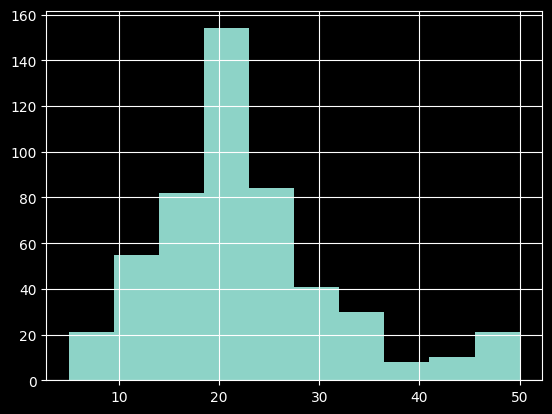

In [111]:
print(f"Loaded {df.shape[0]:,} rows and {df.shape[1]} columns from {data_path}")
df["MEDV"].hist()
plt.show()

## Data Pre-processing

### Outliers

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


feature = 'CRIM'
threshold = 1.5

values = df[feature]

nan_mask = pd.isna(values)
nan_indices = np.where(nan_mask)[0].tolist()
nan_count = len(nan_indices)
    
valid_mask = ~nan_mask
valid_values = values[valid_mask]
valid_indices = np.where(valid_mask)[0].tolist()
    
Q1 = np.nanpercentile(values, 25)  # 使用nanpercentile忽略NaN
Q3 = np.nanpercentile(values, 75)
IQR = Q3 - Q1
    
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR
    
outliers_mask = (valid_values < lower_bound) | (valid_values > upper_bound)
outliers_indices = [valid_indices[i] for i in np.where(outliers_mask)[0]]

len(outliers_indices) / len(valid_values)
    # 收集统计信息
    summary = {
        'feature': feature,
        'total_samples': len(values),
        'valid_samples': len(valid_values),
        'nan_count': nan_count,
        'nan_percentage': nan_count / len(values) * 100,
        'outlier_count': len(outliers_indices),
        'outlier_percentage': len(outliers_indices) / len(valid_values) * 100,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'min_normal': valid_values[~outliers_mask].min() if any(~outliers_mask) else None,
        'max_normal': valid_values[~outliers_mask].max() if any(~outliers_mask) else None,
        'min_outlier': valid_values[outliers_mask].min() if any(outliers_mask) else None,
        'max_outlier': valid_values[outliers_mask].max() if any(outliers_mask) else None,
        'mean': np.nanmean(values),
        'std': np.nanstd(values),
        'median': np.nanmedian(values)
    }
    
    # 详细解释
    if verbose:
        print(f"\n【有效数据统计】:")
        print(f"  有效样本数: {len(valid_values)}")
        print(f"  平均值: {summary['mean']:.4f}")
        print(f"  标准差: {summary['std']:.4f}")
        print(f"  中位数: {summary['median']:.4f}")
        
        print(f"\n【IQR计算】:")
        print(f"  第一四分位数 (Q1): 25%的有效数据 ≤ {Q1:.4f}")
        print(f"  第三四分位数 (Q3): 75%的有效数据 ≤ {Q3:.4f}")
        print(f"  四分位距 (IQR = Q3 - Q1): {IQR:.4f}")
        print(f"  正常值下限: Q1 - {threshold}×IQR = {lower_bound:.4f}")
        print(f"  正常值上限: Q3 + {threshold}×IQR = {upper_bound:.4f}")
        
        print(f"\n【检测结果】:")
        print(f"  异常值数量: {len(outliers_indices)} 个")
        print(f"  异常值比例（相对于有效数据）: {summary['outlier_percentage']:.2f}%")
        
        if outliers_indices:
            print(f"\n【异常值示例】:")
            for i, idx in enumerate(outliers_indices[:5]):  # 显示前5个
                value = values.iloc[idx] if isinstance(values, pd.Series) else values[idx]
                if value < lower_bound:
                    print(f"  样本 {idx}: 值 = {value:.4f} (< 下限 {lower_bound:.4f})")
                else:
                    print(f"  样本 {idx}: 值 = {value:.4f} (> 上限 {upper_bound:.4f})")
            if len(outliers_indices) > 5:
                print(f"  还有 {len(outliers_indices) - 5} 个异常值未显示...")
        
        print(f"\n【数据范围】:")
        print(f"  正常值范围: [{summary['min_normal']:.4f}, {summary['max_normal']:.4f}]")
        print(f"  异常值范围: [{summary['min_outlier']:.4f}, {summary['max_outlier']:.4f}]")
        print("=" * 70)
    
    # 根据handle_nan参数决定返回什么
    if handle_nan == 'separate':
        return outliers_indices, nan_indices, summary
    else:
        # 'ignore'或'remove'模式下，不单独返回NaN索引
        return outliers_indices, summary


def visualize_outliers_with_nan(data, feature, threshold=1.5):
    """
    可视化异常值和NaN值
    """
    # 检测异常值



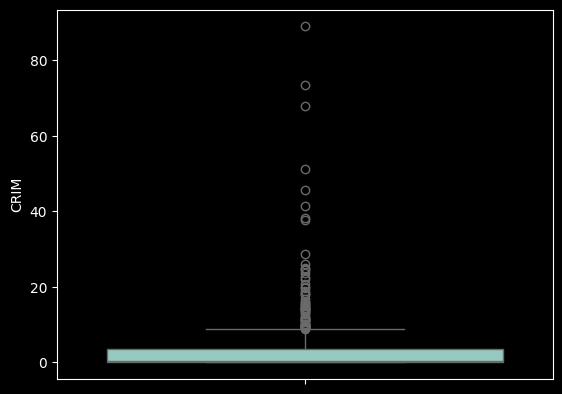

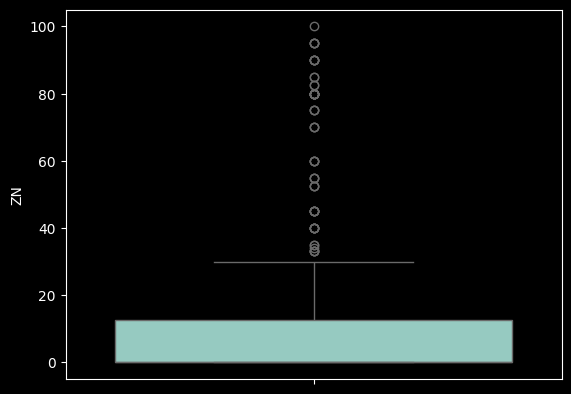

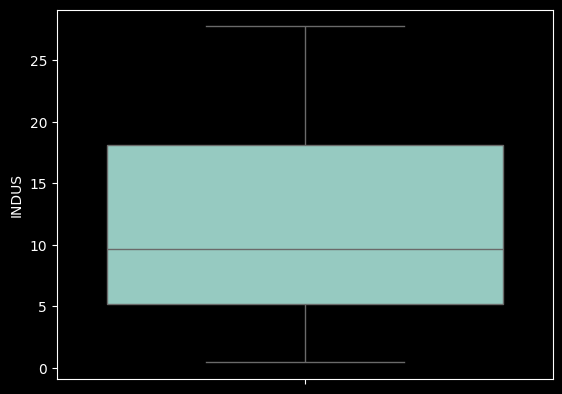

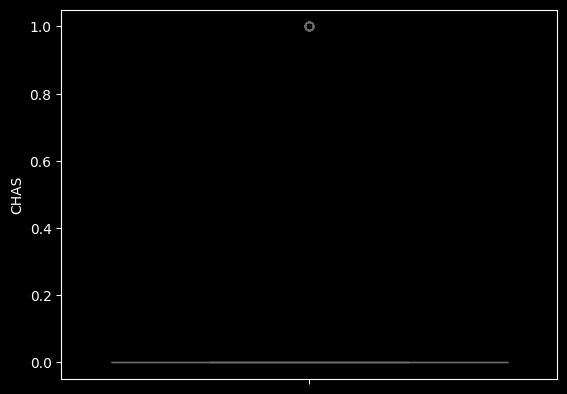

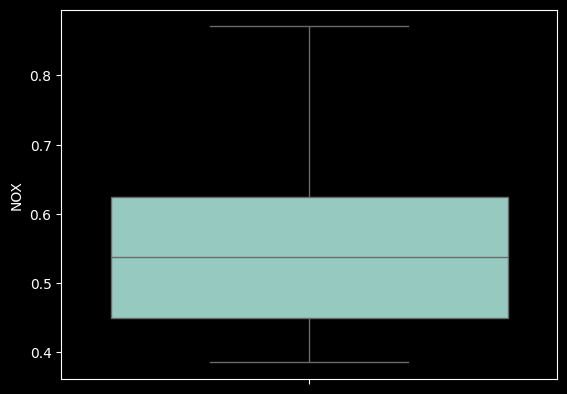

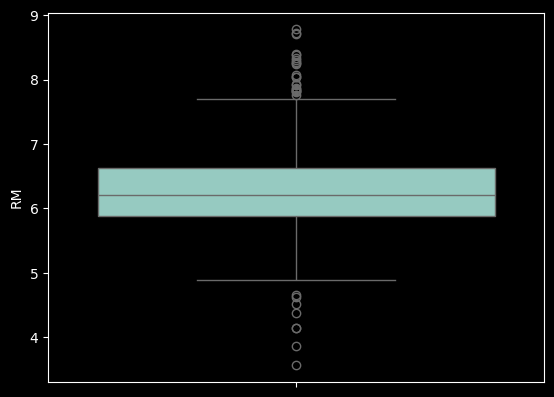

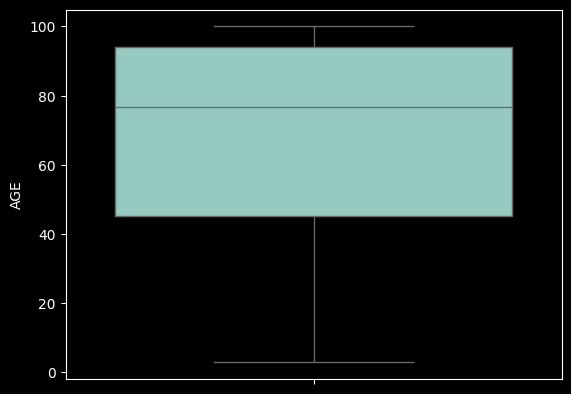

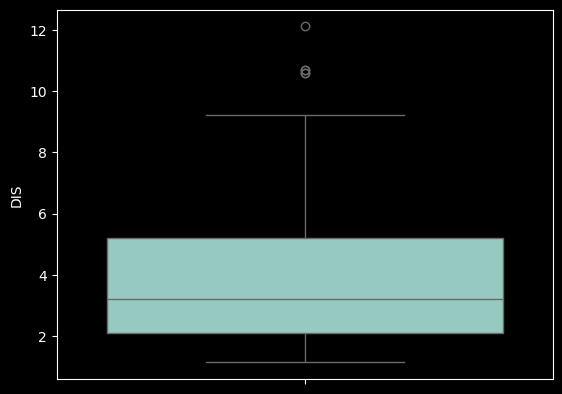

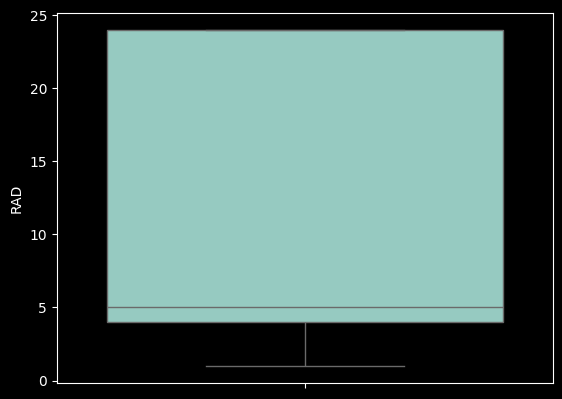

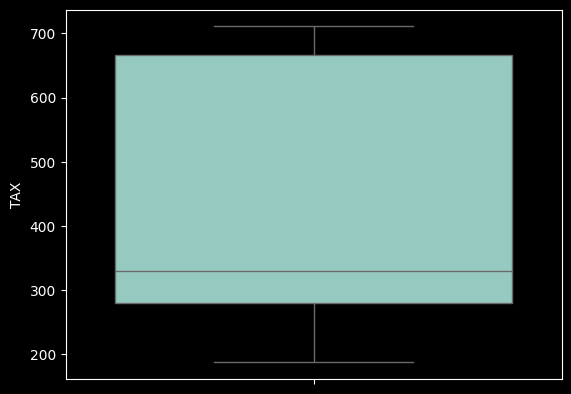

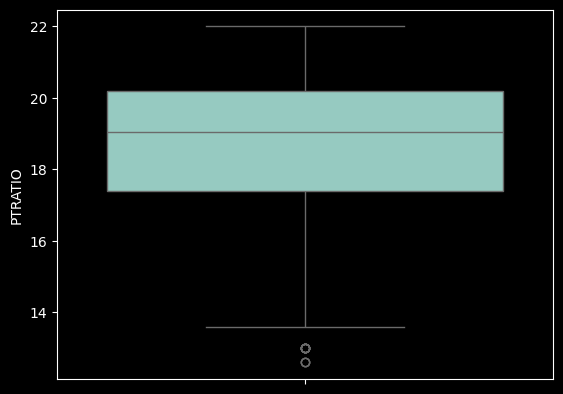

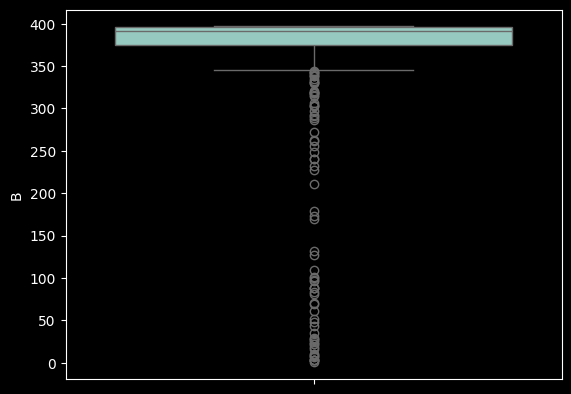

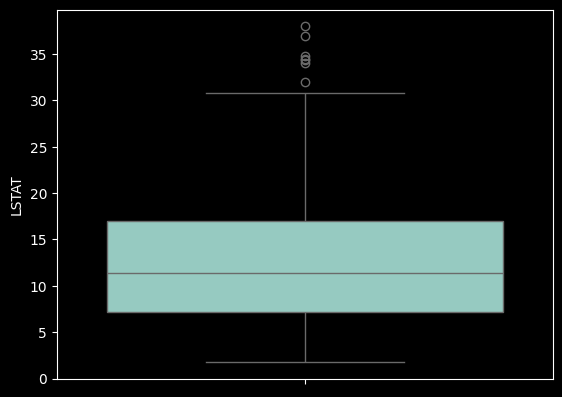

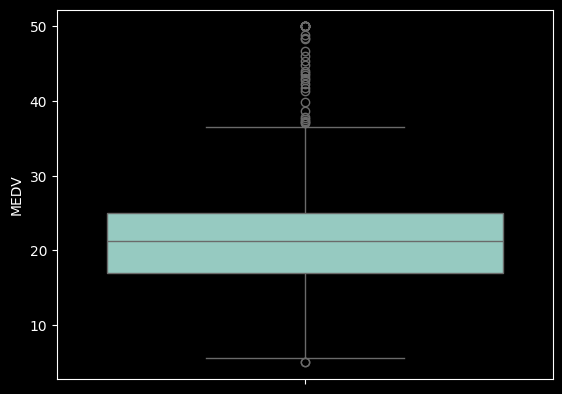

In [119]:
import seaborn as sns
for feature in df.columns:
    sns.boxplot(df[feature])
    plt.show()

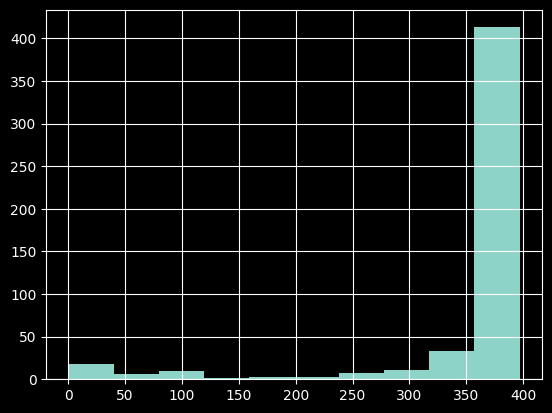

356.6740316205534
91.29486438415783
396.9


In [121]:
df["B"].hist()
plt.show()
print(df["B"].mean())
print(df["B"].std())
print(df["B"].max())

The CRIM feature contain extreme outlier:  
Mean = 3.61  
STD = 8.72  
Some value exceed 40, which is more than 4 std above mean  


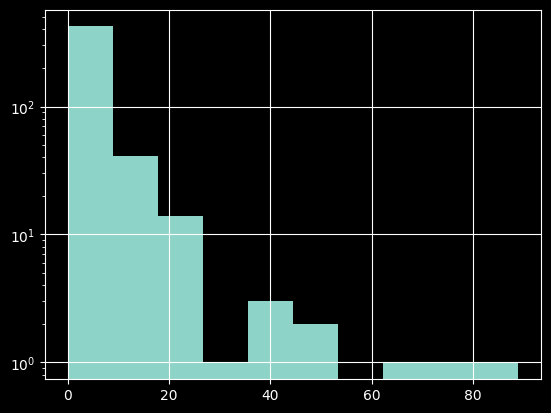

3.6118739711934156
8.720191850151599
88.9762


In [61]:
df["CRIM"].hist()
plt.yscale('log')
plt.show()
print(df["CRIM"].mean())
print(df["CRIM"].std())
print(df["CRIM"].max())

It is reasonable to assume that once crime rate exceed a certain rate in a neighborhood, its effect on the housing price diminishes. So we will treat outliers by winsorization/capping

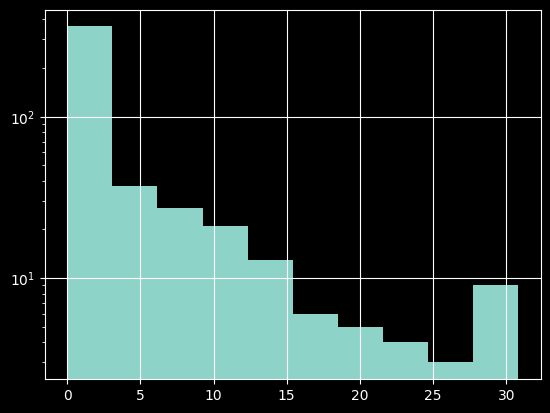

3.2038126790123553
6.187909096867143
30.817264000000595


In [76]:
from scipy.stats.mstats import winsorize

df_processed = df.copy()
upper_limit = df['CRIM'].quantile(0.984)
df_processed['CRIM'] = df['CRIM'].clip(lower=0,upper=upper_limit)
df_processed["CRIM"].hist()
plt.yscale('log')
plt.show()
print(df_processed["CRIM"].mean())
print(df_processed["CRIM"].std())
print(df_processed["CRIM"].max())

### Rescaling

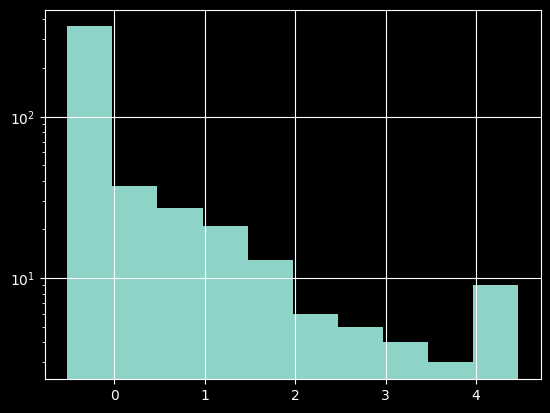

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,-0.517265,0.290525,-1.284840,-0.274265,-0.144217,0.413672,-0.118643,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.082105,0.159686
1,-0.513869,-0.479864,-0.587798,-0.274265,-0.740262,0.194274,0.371156,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.500165,-0.101524
2,-0.513872,-0.479864,-0.587798,-0.274265,-0.740262,1.282714,-0.265225,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.215000,1.324247
3,-0.513051,-0.479864,-1.303877,-0.274265,-0.835284,1.016303,-0.812226,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.367479,1.182758
4,-0.507117,-0.479864,-1.303877,-0.274265,-0.835284,1.228577,-0.511911,1.077737,-0.752922,-1.106115,0.113032,0.441052,NaN,1.487503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.508155,-0.479864,0.123887,-0.274265,0.158124,0.439316,0.020789,-0.625796,-0.982843,-0.803212,1.176466,0.387217,NaN,-0.014454
502,-0.510964,-0.479864,0.123887,-0.274265,0.158124,-0.234548,0.292502,-0.716639,-0.982843,-0.803212,1.176466,0.441052,-0.508558,-0.210362
503,-0.508458,-0.479864,0.123887,-0.274265,0.158124,0.984960,0.803751,-0.773684,-0.982843,-0.803212,1.176466,0.441052,-0.989778,0.148802
504,-0.500559,-0.479864,0.123887,-0.274265,0.158124,0.725672,0.742973,-0.668437,-0.982843,-0.803212,1.176466,0.403225,-0.872271,-0.057989


In [93]:
from sklearn.preprocessing import StandardScaler
df_scaled = df_processed.copy()
df_nscaled = StandardScaler().fit_transform(df_processed)
df_scaled[df_processed.columns] = df_nscaled

df_scaled["CRIM"].hist()
plt.yscale('log')
plt.show()
df_scaled


### Missing Values

1.7% entries are missing in the dataset given

In [90]:
df_scaled.isnull().sum().sum()/(506*14)

np.float64(0.01693958215697346)

We impute those entries using KNN, Becuase the dataset contain only numerical features, the dimension is not too high, and KNN is interpretable (for intepretable models)

In [102]:
from sklearn.impute import KNNImputer

df_imputed = df_scaled.copy()

imputer = KNNImputer(
            n_neighbors=3,
            weights='uniform',
            metric='nan_euclidean'  # Handles missing values in distance calculation
        )
        
df_nimputed = imputer.fit_transform(df_scaled)
df_imputed[df_processed.columns] = df_nimputed
df_imputed.isnull().sum().sum()

np.int64(0)